In [2]:
%matplotlib inline

In [3]:
import os
import sys
import torch
import numpy as np
import torch.nn as nn
from torchsummary import summary
print(torch.__version__)

!pip install path.py;
!pip install fvcore iopath params

1.13.0+cu116
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 3.1 MB/s 
     |████████████████████████████████| 42 kB 1.0 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221213-py3-none-any.whl size=61498 sha256=5f3f8d1bfc961c718f14622a39cb2b866776425d859605d1958ea65edf7dacf5
  Stored in directory: /root/.cache/pip/wheels/14/6d/5c/4fd3efe9b62aeae1e7e68204b54487df288e58e28f3d13fa1e
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31547 sha256=98224b1ca890236ccdab34456dd259e6cf39d2a05e701f0d40204475b5d4a7bf
  Stored in directory: /root/.cache/pip/wheels/89/3e/24/0f349c0b2eeb6965903035f3b00dbb5c9bea437b4a2f18d82c
Successfully built fvcore iopath


In [4]:
from path import Path
!wget http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
# !wget http://modelnet.cs.princeton.edu/ModelNet40.zip
!unzip -q ModelNet10.zip

path = Path("ModelNet10")

dir_path = "ModelNet10"

# loop through the sub directories
for root, dirs, files in os.walk(path):
        for name in files:
            if name == ".DS_Store":
                os.remove(os.path.join(root, name))
        for name in dirs:
            if name == ".DS_Store":
                os.remove(os.path.join(root, name))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

params = {
    "epochs": 500,
    "batch_size": 32,
    "soft_label": False,
    "adv_weight": 0,
    "d_thresh": 0.8,
    "z_dim": 200,
    "z_dis": "norm",
    "model_save_step": 1,
    "g_lr": 0.0025,
    "d_lr": 0.00001,
    "beta": (0.5, 0.999),
    "cube_len": 32,
    "leak_value": 0.2,
    "bias": False,
    "device": device
}

--2022-12-18 04:36:10--  http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
Resolving 3dvision.princeton.edu (3dvision.princeton.edu)... 128.112.136.74
Connecting to 3dvision.princeton.edu (3dvision.princeton.edu)|128.112.136.74|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip [following]
--2022-12-18 04:36:10--  https://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
Connecting to 3dvision.princeton.edu (3dvision.princeton.edu)|128.112.136.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 473402300 (451M) [application/zip]
Saving to: ‘ModelNet10.zip’

ModelNet10.zip      100%[===================>] 451.47M   103MB/s    in 4.5s    

2022-12-18 04:36:15 (100 MB/s) - ‘ModelNet10.zip’ saved [473402300/473402300]



In [5]:
os.getcwd()

'/content'

In [6]:
# from pytorch3d.io import IO

def read_off(file):
    if 'OFF' != file.readline().strip():
        raise('Not a valid OFF header')
    n_verts, n_faces, __ = tuple([int(s) for s in file.readline().strip().split(' ')])
    verts = [[float(s) for s in file.readline().strip().split(' ')] for i_vert in range(n_verts)]
    faces = [[int(s) for s in file.readline().strip().split(' ')][1:] for i_face in range(n_faces)]
    return verts, faces

with open(path/"bathtub/test/bathtub_0107.off", 'r') as f:
    verts, faces = read_off(f)
    
i,j,k = np.array(faces).T
x,y,z = np.array(verts).T
len(x)

1568

## Data Loader

In [7]:
import scipy.ndimage as nd
# import scipy.io as io
import matplotlib
import params

# if params.device.type != 'cpu':
#     matplotlib.use('Agg')

import matplotlib.pyplot as plt
import skimage.measure as sk
from mpl_toolkits import mplot3d
import matplotlib.gridspec as gridspec
from torch.utils import data
from torch.autograd import Variable
import torch
import os
import time
import pickle
from torch import optim
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import pdb
import numpy as np
from tqdm.notebook import tqdm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

# Set the device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("WARNING: CPU only, this will be slow!")

def plot_pointcloud(points, title=""):
    # Sample points uniformly from the surface of the mesh.
    x, y, z = points.clone().detach().cpu().squeeze().unbind(1) 
    fig = plt.figure(figsize=(5, 5))
    ax = Axes3D(fig)
    ax.scatter3D(x, z, -y)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title(title)
    ax.view_init(190, 30)
    plt.show()

In [8]:
import random

class PointSampler(object):
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size
    
    def triangle_area(self, pt1, pt2, pt3):
        side_a = np.linalg.norm(pt1 - pt2)
        side_b = np.linalg.norm(pt2 - pt3)
        side_c = np.linalg.norm(pt3 - pt1)
        s = 0.5 * ( side_a + side_b + side_c)
        return max(s * (s - side_a) * (s - side_b) * (s - side_c), 0)**0.5

    def sample_point(self, pt1, pt2, pt3):
        # barycentric coordinates on a triangle
        # https://mathworld.wolfram.com/BarycentricCoordinates.html
        s, t = sorted([random.random(), random.random()])
        f = lambda i: s * pt1[i] + (t-s)*pt2[i] + (1-t)*pt3[i]
        return (f(0), f(1), f(2))
        
    
    def __call__(self, mesh):
        verts, faces = mesh
        verts = np.array(verts)
        areas = np.zeros((len(faces)))

        for i in range(len(areas)):
            areas[i] = (self.triangle_area(verts[faces[i][0]],
                                           verts[faces[i][1]],
                                           verts[faces[i][2]]))
            
        sampled_faces = (random.choices(faces, 
                                      weights=areas,
                                      cum_weights=None,
                                      k=self.output_size))
        
        sampled_points = np.zeros((self.output_size, 3))

        for i in range(len(sampled_faces)):
            sampled_points[i] = (self.sample_point(verts[sampled_faces[i][0]],
                                                   verts[sampled_faces[i][1]],
                                                   verts[sampled_faces[i][2]]))
        
        return sampled_points


class ToTensor(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        return torch.from_numpy(pointcloud)

In [9]:
# ModelNet DataLoader
from torchvision import transforms, utils
num_points = 1024

train_transforms = transforms.Compose([
                    PointSampler(1024),
                    # Normalize(),
                    # RandRotation_z(),
                    # RandomNoise(),
                    ToTensor()
                    ])

class ModelNetDataset(data.Dataset):

    def __init__(self, root, transforms, args, train_or_val="train"):
        
        
        self.root = root
        self.listdir = os.listdir(self.root)
        self.transforms = transforms
        # print (self.listdir)  
        # print (len(self.listdir)) # 10668

        data_size = len(self.listdir)
#        self.listdir = self.listdir[0:int(data_size*0.7)]
        self.listdir = self.listdir[0:int(data_size)]
        
        print ('data_size =', len(self.listdir)) # train: 10668-1000=9668
        self.args = args

    def __preproc__(self, file):
        verts, faces = read_off(file)
        if self.transforms:
            pointcloud = self.transforms((verts, faces))
        return pointcloud

    def __getitem__(self, index):
        with open(self.root + "/" + self.listdir[index], 'r') as f:
            pointcloud = self.__preproc__(f)
        # mesh = IO().load_mesh(self.root + "/" + self.listdir[index], device=device)
        # # return torch.FloatTensor(mesh)
        # points = sample_points_from_meshes(mesh, num_points)
        # # print(points.data[0:5], points.shape)
        # points = points.reshape((num_points,3))
        # # print(points.data[0:5], points.shape)
        return pointcloud

    def __len__(self):
        return len(self.listdir)

def generateZ(args, batch):

    if params["z_dis"] == "norm":
        Z = torch.Tensor(batch, params["z_dim"]).normal_(0, 0.33).to(params["device"])
    elif params["z_dis"] == "uni":
        Z = torch.randn(batch, params["z_dim"]).to(params["device"]).to(params["device"])
    else:
        print("z_dist is not normal or uniform")

    return Z

# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

data_size = 515
515
torch.Size([1024, 3])


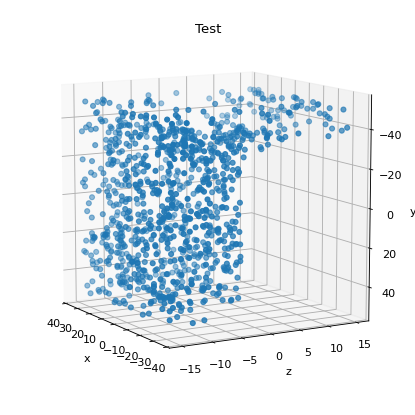

In [10]:
dsets_path = "ModelNet10/bed/train"
args = None

train_dsets = ModelNetDataset(dsets_path, train_transforms, args, "train")
print(len(train_dsets))
mesh = train_dsets[0]
print(mesh.shape)
# mesh2.num_faces_per_mesh()
plot_pointcloud(mesh, "Test")

In [11]:
#PARAMS

# Batch size during training
batch_size = 75

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 1024

# Size of feature maps in generator
ngf = 1024

# Size of feature maps in discriminator
ndf = 1024

# Number of training epochs
num_epochs = 15

# Learning rate for optimizers
# lr = 0.0002
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

e_hidden = 1024        # Number of hidden units in the encoder. Chosen based on AEVB paper page 7, section "Marginal Likelihood"
d_hidden = 1024        # Number of hidden units in the decoder. Chosen based on AEVB paper page 7, section "Marginal Likelihood"
latent_dim = 3  

train_dset_loaders = torch.utils.data.DataLoader(train_dsets, batch_size=batch_size, shuffle=True, num_workers=1)

## Discriminator (PointNet)

In [12]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

class Tnet(nn.Module):
    def __init__(self, k=3):
        super().__init__()
        self.k=k
        self.conv1 = nn.Conv1d(k,64,1)
        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)
        self.fc1 = nn.Linear(1024,512)
        self.fc2 = nn.Linear(512,256)
        self.fc3 = nn.Linear(256,k*k)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)


    def forward(self, input):
        # input.shape == (bs,n,3)
        bs = input.size(0)
        xb = F.relu(self.bn1(self.conv1(input)))
        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = F.relu(self.bn3(self.conv3(xb)))
        pool = nn.MaxPool1d(xb.size(-1))(xb)
        flat = nn.Flatten(1)(pool)
        xb = F.relu(self.bn4(self.fc1(flat)))
        xb = F.relu(self.bn5(self.fc2(xb)))

        #initialize as identity
        init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
        if xb.is_cuda:
            init=init.cuda()
        matrix = self.fc3(xb).view(-1,self.k,self.k) + init
        return matrix


class Transform(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=3)
        self.feature_transform = Tnet(k=64)
        self.conv1 = nn.Conv1d(3,64,1)

        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)


        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)

    def forward(self, input):
        matrix3x3 = self.input_transform(input)
        # batch matrix multiplication
        xb = torch.bmm(torch.transpose(input,1,2), matrix3x3).transpose(1,2)

        xb = F.relu(self.bn1(self.conv1(xb)))

        matrix64x64 = self.feature_transform(xb)
        xb = torch.bmm(torch.transpose(xb,1,2), matrix64x64).transpose(1,2)

        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = self.bn3(self.conv3(xb))
        xb = nn.MaxPool1d(xb.size(-1))(xb)
        output = nn.Flatten(1)(xb)
        return output, matrix3x3, matrix64x64

class PointNet(nn.Module):
    def __init__(self, classes = 2):
        super().__init__()
        self.transform = Transform()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)        

        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3)
        self.logsoftmax = nn.LogSoftmax(dim=-1)
        self.softmax = nn.Softmax(dim=-1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        input = input.float()
        xb, matrix3x3, matrix64x64 = self.transform(input)
        xb = F.relu(self.bn1(self.fc1(xb)))
        xb = F.relu(self.bn2(self.dropout(self.fc2(xb))))
        # print("xb",xb.shape)
        output = self.fc3(xb)
        # print("output of discrim", output.shape, output, output.reshape(-1).shape, output.reshape(-1))
        output.float
        return self.logsoftmax(output), matrix3x3, matrix64x64 #self.logsoftmax(output), torch.sigmoid(output.reshape(-1))

netD = PointNet()
netD.to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

PointNet(
  (transform): Transform(
    (input_transform): Tnet(
      (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
      (fc1): Linear(in_features=1024, out_features=512, bias=True)
      (fc2): Linear(in_features=512, out_features=256, bias=True)
      (fc3): Linear(in_features=256, out_features=9, bias=True)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (feature_transform): Tnet(
      (conv1): Conv1d(64, 64, kernel_size=(1,

## Generator (VAE)

In [13]:
class Encoder(nn.Module):
  def __init__(self):
    """
    Encoder Network. Must inherit from `nn.Module` provided by Pytorch. We only need to define 2 things:
    
    1) The components of the network (layers, activation functions, etc). This is done in __init__().
    2) How the network uses such components to transform the network input into an output. This is done in a method called `forward()`.
    """
    super(Encoder, self).__init__()
    # Define Fully-Connected FeedForward Connections
    self.hidden = nn.Linear(in_features=3 * num_points, out_features=e_hidden)
    # We need two separate layers. One is used for mu one is used for logvar.
    self.mu_layer     = nn.Linear(in_features=e_hidden, out_features=latent_dim)
    self.logvar_layer = nn.Linear(in_features=e_hidden, out_features=latent_dim)
    
  def forward(self, x):
    """Defines how the network transforms the input x into an encoded representation."""
    # Pass input through the first set of connections
    # print("encoder x", x.shape)
    # print(x[0:2])
    x = F.relu(self.hidden(x))
    # print("after relu x", x.shape)
    # Now pass it to one set of connections to get mu, and to another set of connections 
    # to get logvar
    return self.mu_layer(x), self.logvar_layer(x)

class Decoder(nn.Module):
  def __init__(self):
    """
    Decoder Network. Works similarly to the encoder, except it takes an input from the latent space
    and then outputs an image.
    """
    super(Decoder, self).__init__()
    # Define Fully-Connected FeedForward Connections
    self.hidden = nn.Linear(in_features=latent_dim, out_features=d_hidden)
    # Second set of FC connections. Here we only want one output
    self.output_layer = nn.Linear(in_features=d_hidden, out_features=3 * num_points)

  def forward(self, z):
    """Defines how the network transforms the latent input z into a flatten image."""
    # Notice that we use a sigmoid function at the end to restrict output values between 
    # 0 and 1 so they can be interpreted as probabilities (?)
    # print("decoder x", z.shape)
    z = F.relu(self.hidden(z))
    # print("decoder z", z.shape)
    return torch.sigmoid(self.output_layer(z))

class VAE(nn.Module):
  def __init__(self):
    """Puts together Encoder & Decoder with the reparametrization trick."""
    super(VAE, self).__init__()
    self.encoder = Encoder()
    self.decoder = Decoder()

  def sample_latent(self, mu, logvar):
    if self.training:
      # Get standard normal in the shape of mu
      eps = torch.randn_like(mu)
      # Use logarithmic properties to transform logvar to std. Then multiply
      # and sum by latent mu
      return eps.mul(torch.exp(0.5*logvar)).add_(mu)
    else:   # This is used when testing 
      return mu    

  def forward(self, x):
    """Transforms image into latent and then back to its reconstruction."""
    # Feed image to encoder. Obtain mean and logvar for the latent space
    # print("shapes of x", x.shape, x.view(-1, 3 * 1024).shape)
    # print("vae forward x reshape", x.view(-1, 3 * 1024).shape)
    # print(x.view(-1, 3 * 1024))
    latent_mu, latent_logvar = self.encoder(x.view(-1, 3 * num_points)) # (3 x 1024 * b_size)
    # print("latent vars", latent_mu.shape, latent_logvar.shape)
    # Sample from the latent space with the give mean and variance using the 
    # reparametrization trick
    z = self.sample_latent(latent_mu, latent_logvar)
    # print("vae forward z", z.shape)
    # Decode the latent representation
    return self.decoder(z), latent_mu, latent_logvar   


def vae_loss(image, reconstruction, mu, logvar):
  """Loss for the Variational AutoEncoder."""
  # Compute the binary_crossentropy.
  # Notice that we reshape them because in practice we don't receive just 1 image and 1 reconstruction, but we receive a whole batch!
  # print("reshape", image.shape, image.reshape(-1,3* num_points).shape)
  reconstruction_loss = F.binary_cross_entropy(input=reconstruction.reshape(-1, 3 * num_points).float(), target=image.reshape(-1, 3 * num_points).float(), reduction='sum')
  # Compute KL divergence using formula (closed-form)
  kl = 0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
  return reconstruction_loss - kl

# Create the generator
netG = VAE().to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

VAE(
  (encoder): Encoder(
    (hidden): Linear(in_features=3072, out_features=1024, bias=True)
    (mu_layer): Linear(in_features=1024, out_features=3, bias=True)
    (logvar_layer): Linear(in_features=1024, out_features=3, bias=True)
  )
  (decoder): Decoder(
    (hidden): Linear(in_features=3, out_features=1024, bias=True)
    (output_layer): Linear(in_features=1024, out_features=3072, bias=True)
  )
)


In [14]:
class PointCloudVAE(torch.nn.Module):
  def __init__(self, latent_dim):
    super(PointCloudVAE, self).__init__()

    # Define the encoder network
    self.encoder = torch.nn.Sequential(
      # Use PointNet to process the input point cloud
      torch.nn.Conv1d(3, 64, 1),
      torch.nn.BatchNorm1d(64),
      torch.nn.ReLU(),
      torch.nn.Conv1d(64, 128, 1),
      torch.nn.BatchNorm1d(128),
      torch.nn.ReLU(),
      torch.nn.Conv1d(128, 1024, 1),
      torch.nn.BatchNorm1d(1024),
      torch.nn.ReLU()
    )

    # Define the mean and variance layers
    self.mean_layer = torch.nn.Linear(1024, latent_dim)
    self.variance_layer = torch.nn.Linear(1024, latent_dim)

    # Define the decoder network
    self.decoder = torch.nn.Sequential(
      # Use PointNet to process the encoded point cloud
      torch.nn.Conv1d(latent_dim, 128, 1),
      torch.nn.BatchNorm1d(128),
      torch.nn.ReLU(),
      torch.nn.Conv1d(128, 64, 1),
      torch.nn.BatchNorm1d(64),
      torch.nn.ReLU(),
      torch.nn.Conv1d(64, 3, 1),
      torch.nn.BatchNorm1d(3),
      torch.nn.ReLU()
    )

  def forward(self, x):
    # Transpose the dimensions of the input tensor
    x = x.transpose(1, 2)

    # Encode the input point cloud
    x = self.encoder(x)

    # Compute the mean and variance of the latent space
    mean = self.mean_layer(x)
    variance = self.variance_layer(x)

    # Sample a latent vector from the latent space
    latent = mean + torch.exp(0.5 * variance) * torch.randn_like(variance)

    # Decode the latent vector to generate the output point cloud
    x = self.decoder(latent)
    return x

# netG = PointCloudVAE(1024).to(device)

# # Handle multi-gpu if desired
# if (device.type == 'cuda') and (ngpu > 1):
#     netG = nn.DataParallel(netG, list(range(ngpu)))

# # Apply the weights_init function to randomly initialize all weights
# #  to mean=0, stdev=0.02.
# netG.apply(weights_init)

# # Print the model
# print(netG)

In [15]:
# Initialize BCELoss function
criterion = nn.BCELoss()
# criterion = nn.NLLLoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
noise = torch.randn(batch_size, nz, 3, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

def pointnetloss(outputs, labels, m3x3, m64x64, alpha = 0.0001):
    # criterion = torch.nn.NLLLoss()
    criterion = nn.BCELoss()
    bs=labels.size(0)
    id3x3 = torch.eye(3, requires_grad=True).repeat(bs,1,1)
    id64x64 = torch.eye(64, requires_grad=True).repeat(bs,1,1)
    if outputs.is_cuda:
        id3x3=id3x3.cuda()
        id64x64=id64x64.cuda()
    diff3x3 = id3x3-torch.bmm(m3x3,m3x3.transpose(1,2))
    diff64x64 = id64x64-torch.bmm(m64x64,m64x64.transpose(1,2))
    return criterion(outputs, labels) + alpha * (torch.norm(diff3x3)+torch.norm(diff64x64)) / float(bs)

In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_point_cloud(point_cloud):
  # Convert the point cloud tensor to a NumPy array
  point_cloud = point_cloud.cpu().numpy()

  # Extract the x, y, and z coordinates from the point cloud
  x = point_cloud[:, 0]
  y = point_cloud[:, 1]
  z = point_cloud[:, 2]

  # Create a new figure and set the 3D projection
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')

  # Plot the points in 3D space
  ax.scatter(x, y, z)

  # Show the plot
  plt.show()

def plot_losses(losses, num_epochs):
  plt.plot(range(1, num_epochs+1), losses)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.show()

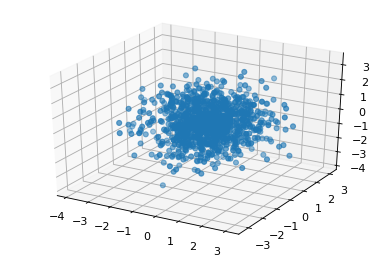

torch.Size([75, 3072])
torch.Size([75, 1024, 3])
torch.Size([75, 1024, 3])


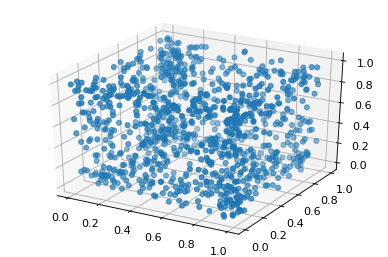

In [18]:
PATH = "/content/checkpoint_model.pt"
PATH_T = "/content/checkpoint_model_toilet.pt"
checkpoint = torch.load(PATH, map_location=torch.device('cpu'))
netG.load_state_dict(checkpoint['netG_state_dict'])

netG.eval()
with torch.no_grad():
  # Sample from standard normal distribution
  z = torch.randn(batch_size, nz, 3, device=device)
  plot_point_cloud(z[1])

  # Reconstruct points from sampled latent vectors
  # recon_points, latent_mu, lateng_logvar = netG(z)
  recon_points, _, _ = netG(z)
  print(recon_points.shape)
  recon_points = recon_points.reshape(batch_size, num_points, 3)
  print(recon_points.shape)
  # recon_points = recon_points.view(recon_points.size(0), 1, 28, 28)
  recon_points = recon_points.cpu()
  # recon_points = recon_points.clamp(0, 1)
  print(recon_points.shape)
  plot_point_cloud(recon_points[1])

  # Plot Generated points

262.85714285714283


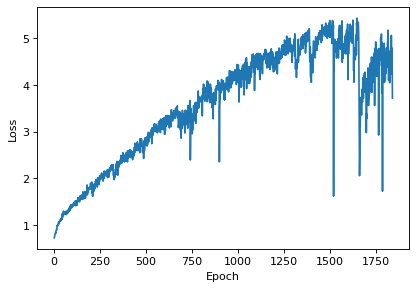

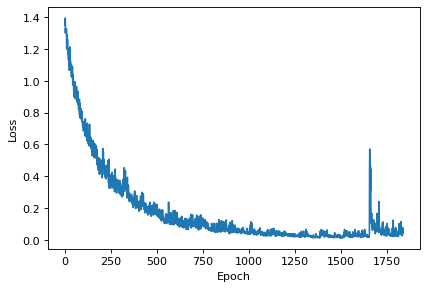

In [19]:
checkpoint = torch.load(PATH, map_location=torch.device('cpu'))
G_losses = []
D_losses = []
G_losses = checkpoint['G_losses']
D_losses = checkpoint['D_losses']
# batch_size 75
print(len(G_losses)/7)

#print(G_losses)
plot_losses(G_losses, len(G_losses))
plot_losses(D_losses, len(D_losses))

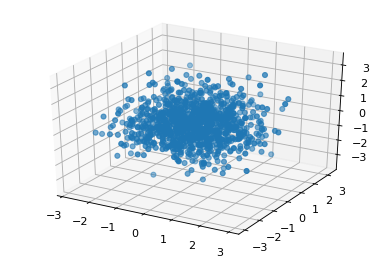

torch.Size([75, 3072])
torch.Size([75, 1024, 3])
torch.Size([75, 1024, 3])


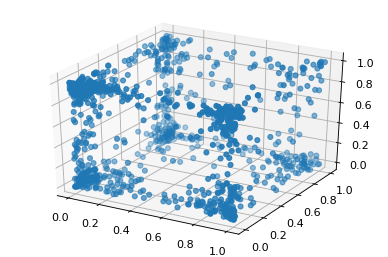

In [24]:
PATH = "checkpoint_model.pt"
PATH_T = "checkpoint_model_toilet.pt"
checkpoint = torch.load(PATH_T, map_location=torch.device('cpu'))
netG.load_state_dict(checkpoint['netG_state_dict'])

netG.eval()
with torch.no_grad():
  # Sample from standard normal distribution
  z = torch.randn(batch_size, nz, 3, device=device)
  plot_point_cloud(z[1])

  # Reconstruct points from sampled latent vectors
  # recon_points, latent_mu, lateng_logvar = netG(z)
  recon_points, _, _ = netG(z)
  print(recon_points.shape)
  recon_points = recon_points.reshape(batch_size, num_points, 3)
  print(recon_points.shape)
  # recon_points = recon_points.view(recon_points.size(0), 1, 28, 28)
  recon_points = recon_points.cpu()
  # recon_points = recon_points.clamp(0, 1)
  print(recon_points.shape)
  plot_point_cloud(recon_points[1])

  # Plot Generated points

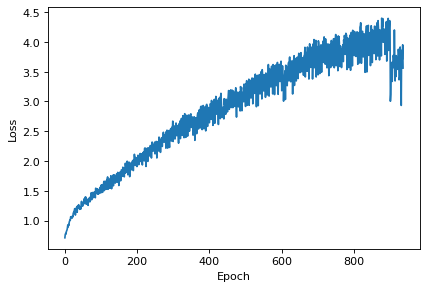

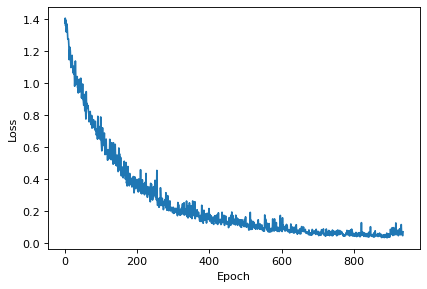

In [25]:
checkpoint = torch.load(PATH_T, map_location=torch.device('cpu'))
G_losses = []
D_losses = []
G_losses = checkpoint['G_losses']
D_losses = checkpoint['D_losses']

#print(G_losses)
plot_losses(G_losses, len(G_losses))
plot_losses(D_losses, len(D_losses))

torch.Size([75, 1024, 3072])
torch.Size([75, 1024, 3072])


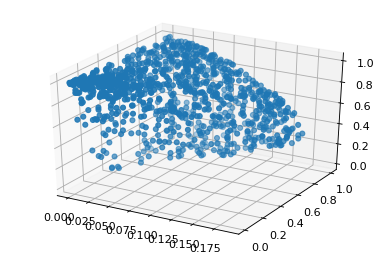

In [26]:
PATH = "checkpoint_model.pt"
PATH_T = "checkpoint_model_toilet.pt"
checkpoint = torch.load(PATH, map_location=torch.device('cpu'))
netG.load_state_dict(checkpoint['netG_state_dict'])

netG.eval()
with torch.no_grad():
  # Sample from standard normal distribution
  for i in range(1):
      z = torch.randn(batch_size, nz, 3, device=device)
      #plot_point_cloud(z[1])

      # Reconstruct points from sampled latent vectors
      # recon_points, latent_mu, lateng_logvar = netG(z)
      recon_points = netG.decoder(z)
      print(recon_points.shape)
      #recon_points = recon_points.reshape(batch_size, num_points, 3)
      #print(recon_points.shape)
      # recon_points = recon_points.view(recon_points.size(0), 1, 28, 28)
      recon_points = recon_points.cpu()
      # recon_points = recon_points.clamp(0, 1)
      print(recon_points.shape)
      plot_point_cloud(recon_points[1])

  # Plot Generated points

torch.Size([75, 1024, 3072])
torch.Size([75, 1024, 3072])


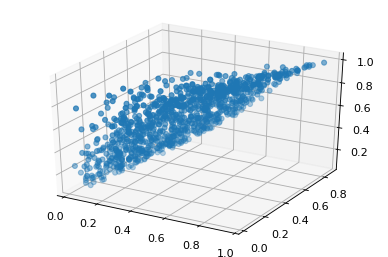

In [27]:
PATH = "checkpoint_model.pt"
PATH_T = "checkpoint_model_toilet.pt"
checkpoint = torch.load(PATH_T, map_location=torch.device('cpu'))
netG.load_state_dict(checkpoint['netG_state_dict'])

netG.eval()
with torch.no_grad():
  # Sample from standard normal distribution
  for i in range(1):
      z = torch.randn(batch_size, nz, 3, device=device)
      #plot_point_cloud(z[1])

      # Reconstruct points from sampled latent vectors
      # recon_points, latent_mu, lateng_logvar = netG(z)
      recon_points = netG.decoder(z)
      print(recon_points.shape)
      #recon_points = recon_points.reshape(batch_size, num_points, 3)
      #print(recon_points.shape)
      # recon_points = recon_points.view(recon_points.size(0), 1, 28, 28)
      recon_points = recon_points.cpu()
      # recon_points = recon_points.clamp(0, 1)
      print(recon_points.shape)
      plot_point_cloud(recon_points[1])

  # Plot Generated points

In [28]:
PATH = "checkpoint_model.pt"
checkpoint = torch.load(PATH, map_location=torch.device('cpu'))
netG.load_state_dict(checkpoint['netG_state_dict'])

dsets_path_test = "ModelNet10/bed/test"
args = None

test_dsets = ModelNetDataset(dsets_path_test, train_transforms, args, "test")
test_dset_loaders = torch.utils.data.DataLoader(test_dsets, batch_size=75, shuffle=False, num_workers=1)

print(len(test_dset_loaders))

data_size = 100
2


In [29]:
def test_epoch(vae, device, test_data):
    # Set evaluation mode for encoder and decoder
    vae.eval()
    with torch.no_grad(): # No need to track the gradients
        for i, data in enumerate(test_data, 0):
            # Move tensor to the proper device
            x = torch.randn(data.shape[0], nz, 3, device=device)
            # Encode data
            print(data.shape)
            #x = torch.reshape(x, (-1,)).float()
            #print(x)
            print(x.shape)
            # x = x.reshape([, 3072])
            reconstruct, mu, log_var = vae(x)
            print(reconstruct.shape)
            # Decode data
            #print(x_norm)
            loss = vae_loss(data, reconstruct, mu, log_var)

    #return val_loss / len(dataloader)
    return loss / len(test_data.dataset)

In [30]:
eval_losses_bed = []
for e in range(10):
    e_l = test_epoch(netG, device, test_dset_loaders)
    print("loss", e_l)
    eval_losses_bed.append(e_l)


plot_losses(eval_losses_bed, len(eval_losses_bed))

torch.Size([75, 1024, 3])
torch.Size([75, 1024, 3])
torch.Size([75, 3072])
torch.Size([25, 1024, 3])
torch.Size([25, 1024, 3])
torch.Size([25, 3072])
loss tensor(2.6978e+13)


KeyboardInterrupt: ignored

In [ ]:
print(eval_losses_bed)

In [32]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [33]:
import tqdm
import pandas as pd

encoded_samples = []
for sample in tqdm.tqdm(test_dsets):
    label = "real"
    # Encode image
    netG.eval()
    with torch.no_grad():
        encoded_img, _  = netG.encoder(sample.view(-1, 3 * num_points).float())
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

for sample in tqdm.tqdm(test_dsets):
  x = torch.randn(nz, 3, device=device)
  label = 'fake'
  netG.eval()
  with torch.no_grad():
      encoded_img, _  = netG.encoder(x.view(-1, 3 * num_points).float())
  # Append to list
  encoded_img = encoded_img.flatten().cpu().numpy()
  encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
  encoded_sample['label'] = label
  encoded_samples.append(encoded_sample)

encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples


from sklearn.manifold import TSNE
import plotly.express as px

px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples.label.astype(str), opacity=0.7)

100%|██████████| 100/100 [00:29<00:00,  3.39it/s]


In [37]:
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))

fig = px.scatter(tsne_results, x=0, y=1, color=encoded_samples.label.astype(str),labels={'fake': 'tsne-2d-one', 'real': 'tsne-2d-two'})
fig.show()

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

